# Email Content: K-Means based Anomaly Detection

This notebook uses Colab to perform anomalous email content determination based on MinHash and K-Means algorithms via PySpark.


Data Source: [CERT Dataset](https://resources.sei.cmu.edu/library/asset-view.cfm?assetid=508099) from Carnegie Mellon University  

## Build environment

Since Colab does not have PySpark module installed, we need to install PySpark and configure the related environment first.

In [2]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 41kB/s 
     |████████████████████████████████| 204kB 60.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=4b47aacbf8fe4a97a2bcb6f0853c9a8c782d097667194a40b2ca789e89d6ebd1
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ge

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please locate to the location where this notebook is saved.

In [4]:
import os
cur_path = "/content/drive/MyDrive/insider-risk-in-spark/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/insider-risk-in-spark


Start Spark session.

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('proj').getOrCreate()

In [6]:
spark

In [7]:
spark.sparkContext.getConf().getAll()

[('spark.sql.warehouse.dir',
  'file:/content/drive/MyDrive/insider-risk-in-spark/spark-warehouse'),
 ('spark.app.id', 'local-1619893895950'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.startTime', '1619893895058'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '37621'),
 ('spark.driver.host', '6960166863e7'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'proj')]

Import necessary modules.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StandardScaler, MinHashLSH, VectorAssembler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.stat import KernelDensity


## Load data

The **email.csv** file size is about 1GB and contains 2.6 million emails.

In [9]:
email = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/email.csv',inferSchema=True,header=True)

In [10]:
email.printSchema()
email.show(5)

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- to: string (nullable = true)
 |-- cc: string (nullable = true)
 |-- bcc: string (nullable = true)
 |-- from: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- attachments: integer (nullable = true)
 |-- content: string (nullable = true)

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338

## Extract word-vector

First, we need to split the email content into lists according to words, and then remove common meaningless words, aka "Stop words".

In [11]:
tokenizer = Tokenizer(inputCol="content", outputCol="words")
wordsData = tokenizer.transform(email)

remover = StopWordsRemover(inputCol="words", outputCol="clean_words")
wordsData = remover.transform(wordsData)

In [12]:
wordsData.show()

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|               words|         clean_words|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338|PC-5758|Dean.Flynn.Hines@...|Nathaniel.Hunter....|                null|Lynn.Adena.Pratt@...|25830|          0|middle f2 systems...|[middle, f2, syst...|[middle, f2, syst...|
|{R0R9-E4GL59IK-29...|01/02/2010 07:12:16|MOH0273|PC-6699|Odonnell-Gage@bel...|                null|    

`CountVectorizer` can convert a collection of text documents to vectors of token counts. 
It can produces sparse representations for the documents over the vocabulary.

We choose 1000 as the vocabulary dimension under consideration. Of course, if the device allows, we can choose a larger dimension to obtain stronger representation ability.

In [13]:
cv = CountVectorizer(inputCol="clean_words", outputCol="features", vocabSize=1000, minDF=2.0)

model = cv.fit(wordsData)

wordsCV = model.transform(wordsData)


Since the MinHash algorithm used in the later steps cannot handle the all-0 vector, we need to remove it in this step.
Of course, if the content of an email generates an all-0 vector as a result, it means that the content of that email is also anomalous. Therefore, the emails removed in this step also need to be treated as anomalous emails.

In [14]:
all0vector = Vectors.dense([0]*1000) 

# Filter the empty Sparse Vector
def no_empty_vector(value):
    if value != all0vector:
        return True
    else:
        return False


no_empty_vector_udf = udf(no_empty_vector, BooleanType())
wordsCV = wordsCV.filter(no_empty_vector_udf('features'))


In [15]:
wordsCV.show()

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|               words|         clean_words|            features|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338|PC-5758|Dean.Flynn.Hines@...|Nathaniel.Hunter....|                null|Lynn.Adena.Pratt@...|25830|          0|middle f2 systems...|[middle, f2, syst...|[middle, f2, syst...|(1000,[28,59,105,...|
|{R0R9-E4GL59IK-29..

## Dimension reduction by MinHash

In this step, we reduce the dimensionality of the features used by using the MinHash algorithm, while ensuring that the similarity between the data is maintained. Also, this converts the sparse features into dense features.

In [16]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=20)
model = mh.fit(wordsCV)
wordsHash = model.transform(wordsCV)

In [17]:
wordsHash.show()

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|               words|         clean_words|            features|              hashes|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338|PC-5758|Dean.Flynn.Hines@...|Nathaniel.Hunter....|                null|Lynn.Adena.Pratt@...|25830|          0|middle f2 systems...|[middle, f2, syst...|

In [18]:
id_hash = wordsHash.select('id', 'hashes')

Since the features generated by the MinHashLSH function in Spark are a 20-dimensional list composed of each single-element DenseVector, we need to convert it to a flat 20-dimensional DenseVector.

Therefore, we first split the list into 20 columns, then convert the DenseVector in each column to a pure value, and finally merge the 20 columns.

In [19]:
sc = spark.sparkContext

numAttrs = 20
attrs = sc.parallelize(["hash_" + str(i) for i in range(numAttrs)]).zipWithIndex().collect()
for name, index in attrs:
    id_hash = id_hash.withColumn(name, id_hash['hashes'].getItem(index))

In [20]:
id_hash.show()

+--------------------+--------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|                  id|              hashes|        hash_0|        hash_1|        hash_2|        hash_3|        hash_4|        hash_5|        hash_6|        hash_7|        hash_8|        hash_9|       hash_10|       hash_11|       hash_12|       hash_13|       hash_14|       hash_15|       hash_16|       hash_17|       hash_18|       hash_19|
+--------------------+--------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------

In [22]:
udf_getNumber = udf(lambda x: int(x[0]), LongType())

for col_num in range(20):
    id_hash = id_hash.withColumn('hash_'+str(col_num), udf_getNumber('hash_'+str(col_num)))

In [23]:
id_hash.show()

+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|                  id|              hashes|   hash_0|   hash_1|   hash_2|   hash_3|   hash_4|   hash_5|   hash_6|   hash_7|   hash_8|   hash_9|  hash_10|  hash_11|  hash_12|  hash_13|  hash_14|  hash_15|  hash_16|  hash_17|  hash_18|  hash_19|
+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|{R3I7-S4TX96FG-82...|[[1.09789512E8], ...|109789512|  7086169|402084055|  1388703| 21536609|177176809|  6548071| 12081413| 90686261|112878414| 57761108| 76797091|212726905| 75613379|167557803|103479472| 46576933|  1787169| 19514016| 79126192|
|{R0R9-E4GL59IK-29...|[[

In [24]:
hash_cols = ['hash_'+str(i) for i in range(20)]

assembler = VectorAssembler(inputCols=hash_cols, outputCol="features")
id_hash = assembler.transform(id_hash)

In [25]:
id_hash.show()

+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+
|                  id|              hashes|   hash_0|   hash_1|   hash_2|   hash_3|   hash_4|   hash_5|   hash_6|   hash_7|   hash_8|   hash_9|  hash_10|  hash_11|  hash_12|  hash_13|  hash_14|  hash_15|  hash_16|  hash_17|  hash_18|  hash_19|            features|
+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+
|{R3I7-S4TX96FG-82...|[[1.09789512E8], ...|109789512|  7086169|402084055|  1388703| 21536609|177176809|  6548071| 12081413| 90686261|112878414| 57761108| 76797091|212726905| 75613379|167557803|103479472| 4

## Data rescale 

At the same time, we can find that the values in the FEATURES we obtained are very large, which is not conducive to subsequent steps such as model training. Therefore, we need to use Scaler to scale them down to a suitable size.

In [26]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(id_hash)

# Normalize each feature to have unit standard deviation.
id_hash_scaled = scalerModel.transform(id_hash)
id_hash_scaled.show()

+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+
|                  id|              hashes|   hash_0|   hash_1|   hash_2|   hash_3|   hash_4|   hash_5|   hash_6|   hash_7|   hash_8|   hash_9|  hash_10|  hash_11|  hash_12|  hash_13|  hash_14|  hash_15|  hash_16|  hash_17|  hash_18|  hash_19|            features|      scaledFeatures|
+--------------------+--------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|[[1.09789512E8], ...|109789512|  7086169|402084055|  1388703| 21536609|177176809|  6548071| 12081413| 90686261|112878414

In [27]:
id_hash_scaled = id_hash_scaled.select('id','scaledFeatures')
id_hash_scaled.show()

+--------------------+--------------------+
|                  id|      scaledFeatures|
+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|[0.87188617312435...|
|{R0R9-E4GL59IK-29...|[2.18769315925287...|
|{G2B2-A8XY58CP-28...|[0.51198732106022...|
|{A3A9-F4TH89AA-83...|[0.08814073808128...|
|{E8B7-C8FZ88UF-29...|[0.26030343710261...|
|{X8T7-A6BT54FP-72...|[0.59150850599651...|
|{H5J6-G2RS59KI-83...|[0.58044169669859...|
|{D9T8-M1HJ89XP-63...|[0.49436034718793...|
|{V3L7-L2RB92RV-91...|[0.73497742184762...|
|{D5K9-P0IJ71WK-63...|[0.51198732106022...|
|{R0A5-U4YQ17EA-34...|[0.11683452125150...|
|{Y8Z6-X5HU72BM-73...|[0.13446149512380...|
|{K3B8-S0RJ27BU-68...|[2.32460191052960...|
|{J7Y1-G7KD78BQ-41...|[0.36851840520912...|
|{D7P4-Z0PP26KM-17...|[0.00861955314499...|
|{P6J4-Y0XJ63II-57...|[0.78580482361369...|
|{K7Y5-V5IP47OA-83...|[0.42590597154956...|
|{R9V2-W5OA43XS-14...|[0.62020228916673...|
|{X4R4-F1BP75UA-02...|[0.86081936382643...|
|{N4L7-S2MN81EJ-50...|[0.4832935

In [28]:
hash_scaled = id_hash_scaled.select('scaledFeatures')
hash_scaled.show()

+--------------------+
|      scaledFeatures|
+--------------------+
|[0.87188617312435...|
|[2.18769315925287...|
|[0.51198732106022...|
|[0.08814073808128...|
|[0.26030343710261...|
|[0.59150850599651...|
|[0.58044169669859...|
|[0.49436034718793...|
|[0.73497742184762...|
|[0.51198732106022...|
|[0.11683452125150...|
|[0.13446149512380...|
|[2.32460191052960...|
|[0.36851840520912...|
|[0.00861955314499...|
|[0.78580482361369...|
|[0.42590597154956...|
|[0.62020228916673...|
|[0.86081936382643...|
|[0.48329353789000...|
+--------------------+
only showing top 20 rows



The amount of data was simply too large to be handled by Colab during the modeling process and caused a disconnection of its Java back-end server. Therefore, we only extract a portion of the data for demonstration.

In [29]:
id_hash_sub = id_hash_scaled.sample(withReplacement=False, fraction=0.001, seed=42)

In [32]:
id_hash_sub_split = id_hash_sub.withColumn("scaledHash", vector_to_array("scaledFeatures")).select(['id'] + [col("scaledHash")[i] for i in range(20)])

In [33]:
id_hash_sub_split.show()

+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+
|                  id|       scaledHash[0]|       scaledHash[1]|      scaledHash[2]|       scaledHash[3]|      scaledHash[4]|      scaledHash[5]|      scaledHash[6]|       scaledHash[7]|       scaledHash[8]|      scaledHash[9]|      scaledHash[10]|      scaledHash[11]|      scaledHash[12]|     scaledHash[13]|    scaledHash[14]|     scaledHash[15]|     scaledHash[16]|     scaledHash[17]|      scaledHash[18]|      scaledHash[19]|
+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-----------

Also, the data was stored and then retrieved for manipulation to speed up the subsequent modeling process.

In [34]:
id_hash_sub_split.write.csv('/content/drive/MyDrive/insider-risk-in-spark/data/id_hash_sub_split.csv', header = True, mode = 'error')

## Retrieve saved data

In this step, we need to retrieve the previously saved data and perform the modeling operation. If the runtime was ever interrupted after the previous step, you need to run the Build environment section at the beginning of the notebook.

In [35]:
id_hash_sub_split = spark.read.csv( '/content/drive/MyDrive/insider-risk-in-spark/data/id_hash_sub_split.csv',inferSchema=True,header=True)

In [36]:
id_hash_sub_split.show()

+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+
|                  id|       scaledHash[0]|      scaledHash[1]|      scaledHash[2]|       scaledHash[3]|      scaledHash[4]|      scaledHash[5]|      scaledHash[6]|      scaledHash[7]|      scaledHash[8]|       scaledHash[9]|     scaledHash[10]|     scaledHash[11]|     scaledHash[12]|     scaledHash[13]|      scaledHash[14]|     scaledHash[15]|     scaledHash[16]|      scaledHash[17]|     scaledHash[18]|      scaledHash[19]|
+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------

In [39]:
hash_cols = ['scaledHash['+str(i)+']' for i in range(20)]

assembler = VectorAssembler(inputCols=hash_cols, outputCol="scaledFeatures")
id_hash_sub = assembler.transform(id_hash_sub_split).select('id','scaledFeatures')

In [40]:
id_hash_sub.show()

+--------------------+--------------------+
|                  id|      scaledFeatures|
+--------------------+--------------------+
|{R0A8-D0KA23YU-26...|[0.33982462203890...|
|{C4W6-P6ZE51MH-58...|[1.02642189827338...|
|{Q7V6-N6NE83EZ-03...|[0.73497742184762...|
|{R1W9-Z1SB61VN-25...|[0.23160965393239...|
|{T8V6-A0YZ92MM-43...|[0.10576771195358...|
|{J5S7-D3EN76YN-47...|[2.31353510123168...|
|{V6X5-A6JS37ZC-78...|[0.26030343710261...|
|{K9Q3-C6MB20EN-05...|[0.52305413035815...|
|{E2N0-S3EQ10XZ-59...|[0.18528889688987...|
|{X2V0-G5QC95QV-97...|[0.48329353789000...|
|{W8Y0-Q6VB44AY-48...|[0.00861955314499...|
|{Z3O3-C5WT32II-33...|[0.38614537908142...|
|{J0V1-Q3VT17LQ-96...|[2.15899937608265...|
|{I3C6-O0BG43IS-00...|[0.07707392878336...|
|{Z1D7-Y9ON91MY-18...|[1.30679956540122...|
|{E8R7-M4NQ76XB-96...|[1.76384657627393...|
|{M2B5-U6QV73PC-27...|[0.13446149512380...|
|{X1H9-X8SF98ZC-71...|[0.26030343710261...|
|{K3G8-R5SI91WD-94...|[0.26030343710261...|
|{J9N9-W9ZA59WS-07...|[0.3287578

## K-Means Modeling

Now we need to train the K-Means model. And determine the most suitable number of clustering categories.

In [62]:
errors = []
results = []

for k in range(2,10):
    kmeansmodel = KMeans().setK(k).setMaxIter(10).setFeaturesCol('scaledFeatures').setPredictionCol('prediction').fit(id_hash_sub)

    print("With K={}".format(k))
    
    kmeans_results = kmeansmodel.transform(id_hash_sub)
    results.append(kmeans_results)
    #for item in kmeans_results:
    #    print(str(item[0])+' is predcted as cluster'+ str(item[1]))
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    evaluator.setFeaturesCol('scaledFeatures').setPredictionCol("prediction")

    silhouette = evaluator.evaluate(kmeans_results)
    errors.append(silhouette)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    
    print('--'*30 + '\n')

With K=2
Silhouette with squared euclidean distance = 0.8038431184138418
------------------------------------------------------------

With K=3
Silhouette with squared euclidean distance = 0.3655091932655988
------------------------------------------------------------

With K=4
Silhouette with squared euclidean distance = 0.30220805261875183
------------------------------------------------------------

With K=5
Silhouette with squared euclidean distance = 0.18364194160396685
------------------------------------------------------------

With K=6
Silhouette with squared euclidean distance = 0.17257073253791888
------------------------------------------------------------

With K=7
Silhouette with squared euclidean distance = 0.124131815077253
------------------------------------------------------------

With K=8
Silhouette with squared euclidean distance = 0.12207521310576692
------------------------------------------------------------

With K=9
Silhouette with squared euclidean distance 

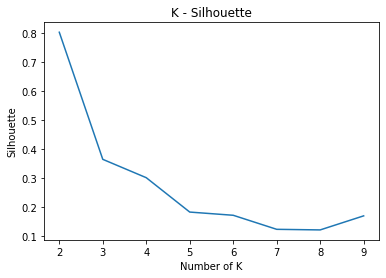

In [63]:
plt.figure()
k_number = range(2,10)
plt.plot(k_number,errors)
plt.xlabel('Number of K')
plt.ylabel('Silhouette')
plt.title('K - Silhouette')
plt.show()

Based on the variation of Silhouette with squared euclidean distance with k in the above figure, according to the elbow principle, we can consider 5 as the most appropriate number of categories that can bring the maximum classification gain with as few categories as possible.

In [64]:
k = 5

kmeansmodel = KMeans().setK(k).setMaxIter(10).setFeaturesCol('scaledFeatures').setPredictionCol('prediction').fit(id_hash_sub)

kmeans_results = kmeansmodel.transform(id_hash_sub)

In [69]:
clusterCenters = kmeansmodel.clusterCenters()

In [74]:
kmeans_results.show()

+--------------------+--------------------+----------+
|                  id|      scaledFeatures|prediction|
+--------------------+--------------------+----------+
|{R0A8-D0KA23YU-26...|[0.33982462203890...|         0|
|{C4W6-P6ZE51MH-58...|[1.02642189827338...|         4|
|{Q7V6-N6NE83EZ-03...|[0.73497742184762...|         4|
|{R1W9-Z1SB61VN-25...|[0.23160965393239...|         0|
|{T8V6-A0YZ92MM-43...|[0.10576771195358...|         0|
|{J5S7-D3EN76YN-47...|[2.31353510123168...|         1|
|{V6X5-A6JS37ZC-78...|[0.26030343710261...|         2|
|{K9Q3-C6MB20EN-05...|[0.52305413035815...|         2|
|{E2N0-S3EQ10XZ-59...|[0.18528889688987...|         2|
|{X2V0-G5QC95QV-97...|[0.48329353789000...|         2|
|{W8Y0-Q6VB44AY-48...|[0.00861955314499...|         2|
|{Z3O3-C5WT32II-33...|[0.38614537908142...|         2|
|{J0V1-Q3VT17LQ-96...|[2.15899937608265...|         2|
|{I3C6-O0BG43IS-00...|[0.07707392878336...|         2|
|{Z1D7-Y9ON91MY-18...|[1.30679956540122...|         2|
|{E8R7-M4N

Based on the clustering results obtained from the final model, the clustering of each data point to its corresponding category center is calculated.

The few data points farthest from their corresponding clustering centers are the anomalous emails we are looking for.

In [104]:
df_list = []
for row in kmeans_results.collect():
    id = row['id']
    distance = np.linalg.norm(row['scaledFeatures'] - clusterCenters[row['prediction']])
    item = (id, row['scaledFeatures'],row['prediction'], str(distance))
    df_list.append(item)

rdd = sc.parallelize(df_list)
results = spark.createDataFrame(rdd,['id', 'scaledFeatures','prediction', 'distance'])

In [108]:
results = results.withColumn('distance', col('distance').cast(DoubleType()))
results = results.orderBy('distance', ascending=False)
results.show()

+--------------------+--------------------+----------+------------------+
|                  id|      scaledFeatures|prediction|          distance|
+--------------------+--------------------+----------+------------------+
|{U6Y0-B2DF26US-02...|[2.31353510123168...|         1|19.427072205336874|
|{D4D6-O3CF39OC-21...|[0.83212558065621...|         1|18.143180470713634|
|{K1R6-N7JJ70ZO-34...|[5.87030990453206...|         3|14.008035284557495|
|{E7R0-U5JS84PD-21...|[8.66752641123606...|         1| 13.97753947414746|
|{I0N3-A1QK61ZK-75...|[0.95796752263501...|         1|12.719678810987869|
|{P8K2-Q4DT05VF-43...|[0.80343179748598...|         3|12.147797529898357|
|{T0D2-B4KJ27QT-86...|[0.24267646323031...|         3|11.671180376402477|
|{R6K4-W3ZB83DC-12...|[0.32875781274097...|         3|11.176974469207211|
|{G8R9-C8WG63VR-61...|[1.93600927529525...|         3|11.123007263557112|
|{P5L9-A9RC25YE-71...|[1.41501453350772...|         3| 11.09071675067448|
|{Q8D1-I2CB87LP-11...|[3.3313374463600

In addition, we can also get a more visualized range of the distance distribution by drawing the image of the KDE probability distribution for each distance. And with this, we can determine the appropriate distance threshold as the criterion for judging anomalies.

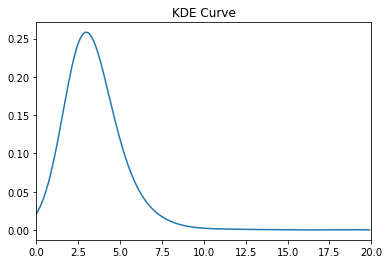

In [112]:
distance = results.select('distance')
kd = KernelDensity()
kd.setSample(distance.rdd.map(lambda x: x[0]))

all_distance = list(np.arange(0,20,0.1))
prob_all_distance = kd.estimate(all_distance)

prob_max = max(prob_all_distance)
prob_min = min(prob_all_distance)


plt.plot(all_distance,prob_all_distance)
plt.xlim(0, 20)
plt.title("KDE Curve")
plt.show()

## Example of anomalous email

Based on the above steps, we obtain the list of emails sorted by anomaly degree.

For the obtained list of abnormal emails, we can take out the content of that email and review it.

In [115]:
targetId = results.take(1)[0]['id']
targetId

In [117]:
targetEmail = email.where(col('id') == targetId)
targetEmail.show()

+--------------------+-------------------+-------+-------+--------------------+--------------------+----+--------------------+-----+-----------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc| bcc|                from| size|attachments|             content|
+--------------------+-------------------+-------+-------+--------------------+--------------------+----+--------------------+-----+-----------+--------------------+
|{U6Y0-B2DF26US-02...|07/21/2010 11:25:40|COF0120|PC-2559|Tallulah.Liberty....|Brianna.Rebecca.M...|null|Clio.Ocean.Faulkn...|37949|          0|prince prince pri...|
+--------------------+-------------------+-------+-------+--------------------+--------------------+----+--------------------+-----+-----------+--------------------+



In [119]:
targetEmail.collect()[0]['content']

'prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince prince ankh prince prince prince prince prince ankh prince prince prince'

We can see that the first abnormal email in the list is an email containing only "prince" content. This shows that our algorithm is really effective in finding anomalous emails in the huge volume of emails.

P.S. In addition to the classical K-Means algorithm used in the previous section, the Bisecting KMeans algorithm described below can also be used as an alternative when we have high requirements on the running time of the algorithm.

In [41]:
from pyspark.ml.clustering import BisectingKMeans
k = 2
bkm = BisectingKMeans().setK(k).setMaxIter(1).setFeaturesCol('scaledFeatures').setPredictionCol('prediction')
model = bkm.fit(id_hash_sub)

results = model.transform(id_hash_sub)

results.show()

+--------------------+--------------------+----------+
|                  id|      scaledFeatures|prediction|
+--------------------+--------------------+----------+
|{R0A8-D0KA23YU-26...|[0.33982462203890...|         0|
|{C4W6-P6ZE51MH-58...|[1.02642189827338...|         1|
|{Q7V6-N6NE83EZ-03...|[0.73497742184762...|         0|
|{R1W9-Z1SB61VN-25...|[0.23160965393239...|         0|
|{T8V6-A0YZ92MM-43...|[0.10576771195358...|         0|
|{J5S7-D3EN76YN-47...|[2.31353510123168...|         1|
|{V6X5-A6JS37ZC-78...|[0.26030343710261...|         0|
|{K9Q3-C6MB20EN-05...|[0.52305413035815...|         0|
|{E2N0-S3EQ10XZ-59...|[0.18528889688987...|         0|
|{X2V0-G5QC95QV-97...|[0.48329353789000...|         0|
|{W8Y0-Q6VB44AY-48...|[0.00861955314499...|         0|
|{Z3O3-C5WT32II-33...|[0.38614537908142...|         0|
|{J0V1-Q3VT17LQ-96...|[2.15899937608265...|         0|
|{I3C6-O0BG43IS-00...|[0.07707392878336...|         0|
|{Z1D7-Y9ON91MY-18...|[1.30679956540122...|         0|
|{E8R7-M4N